In [12]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg")
sys.path.append("/Users/jameskitchens/Documents/GitHub/tskit_arg_visualizer")

import sparg
import tskit_arg_visualizer as viz
import importlib
importlib.reload(sparg)
import tskit
import msprime
import math
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt

In [14]:
ts = tskit.load("/Users/jameskitchens/Documents/GitHub/sparg/figures/Fig6_coverage/code/args/simplified_args/rep2.trees")

## Preparing the ARG for analysis

We select a subset of samples and simplify the ARG using a custom function to avoid loosing recombination nodes. We then chop the ARG at 10,000 generations in the past as we are not interested in deeper times.

In [16]:
np.random.seed(10)

cutoff = 2000
samples = list(np.random.choice(ts.samples(), 50, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
ts_final, maps_final = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)
ts_chopped = sparg.chop_arg(ts=ts_final, time=cutoff)

## Calculating spatial estimates

WARNING: Initializing the sparg.SpatialARG can take some time depending on the size of your ARG. This calculates a number of spatial parameters for your ARG given the locations of your sample nodes. These are stored as attributes of the sparg.SpatialARG and include:

- ts
- locations_of_individuals
- paths_shared_time_matrix
- paths
- node_paths_shared_times
- node_paths
- inverted_paths_shared_time_matrix
- root_locations
- path_dispersal_distances
- dispersal_rate_matrix
- fishers_information_1
- fishers_information_2

In [17]:
spatial_arg = sparg.SpatialARG(ts=ts_chopped, verbose=True)

Prepared input parameters - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.0


100%|████████████████████████████████████████████| 2040/2040 [00:02<00:00, 933.16it/s]


Calculated covariance matrix - Section Elapsed Time: 2.24 - Total Elapsed Time: 2.25
Inverted covariance matrix - Section Elapsed Time: 0.1 - Total Elapsed Time: 2.35
Created root locations vector - Section Elapsed Time: 4.7 - Total Elapsed Time: 7.05
Estimated dispersal rate - Section Elapsed Time: 0.0 - Total Elapsed Time: 7.05
Calculated Fisher's information matrices - Section Elapsed Time: 0.0 - Total Elapsed Time: 7.05
Completed building SpatialARG object - Total Elapsed Time: 7.05


## Estimating the locations of ancestors using different methods

We can estimate the locations of ancestors using the full ARG, ARGs trimmed to windows of different sizes, or a midpoint method (similar to Wohns et al. 2022).

In [18]:
spatial_arg.dispersal_rate_matrix = np.array([[0.25*0.25+0.5,0],[0,0.25*0.25+0.5]])

In [19]:
random_ancestors = sparg.generate_random_ancestors_dataframe(ts=ts_sim, number_of_ancestors=1000, cutoff=2000, include_locations=True, seed=10)

/Users/jameskitchens/Documents/GitHub/sparg/sparg/__init__.py:43: UserWarning: Sample -1 does not have an ancestral node at time 988 in tree. Returning None.
  warnings.warn(f"Sample %s does not have an ancestral node at time %s in tree. Returning None." % (u, time))


TypeError: Index must be of integer type, not 'NoneType'

In [20]:
random_ancestors = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(df=random_ancestors, spatial_arg=spatial_arg)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
random_ancestors = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=random_ancestors, spatial_arg=spatial_arg, window_size=0, use_theoretical_dispersal=True)
#random_ancestors = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=random_ancestors, spatial_arg=spatial_arg, window_size=20, use_theoretical_dispersal=True)
#random_ancestors = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=random_ancestors, spatial_arg=spatial_arg, window_size=40, use_theoretical_dispersal=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
sparg.estimate_locations_of_ancestors_in_dataframe_using_window_orig(df=random_ancestors, spatial_arg=spatial_arg, window_size=0, use_theoretical_dispersal=True)

  0%|          | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
random_ancestors = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=random_ancestors, spatial_arg=spatial_arg, window_size=100, use_theoretical_dispersal=True)
random_ancestors = sparg.estimate_locations_of_ancestors_in_dataframe_using_midpoint(df=random_ancestors, spatial_arg=spatial_arg, simplify=True)

In [ ]:
random_ancestors["arg_error_0"] = random_ancestors["true_location_0"] - random_ancestors["arg_estimated_location_0"]
random_ancestors["arg_abs_error_0"] = abs(random_ancestors["arg_error_0"])
random_ancestors["window_0_error_0"] = random_ancestors["true_location_0"] - random_ancestors["window_0_estimated_location_0"]
random_ancestors["window_0_abs_error_0"] = abs(random_ancestors["window_0_error_0"])
random_ancestors["window_20_error_0"] = random_ancestors["true_location_0"] - random_ancestors["window_20_estimated_location_0"]
random_ancestors["window_20_abs_error_0"] = abs(random_ancestors["window_20_error_0"])
random_ancestors["window_40_error_0"] = random_ancestors["true_location_0"] - random_ancestors["window_40_estimated_location_0"]
random_ancestors["window_40_abs_error_0"] = abs(random_ancestors["window_40_error_0"])
random_ancestors["window_100_error_0"] = random_ancestors["true_location_0"] - random_ancestors["window_100_estimated_location_0"]
random_ancestors["window_100_abs_error_0"] = abs(random_ancestors["window_100_error_0"])
random_ancestors["midpoint_error_0"] = random_ancestors["true_location_0"] - random_ancestors["midpoint_estimated_location_0"]
random_ancestors["midpoint_abs_error_0"] = abs(random_ancestors["midpoint_error_0"])

### Error and variances of methods

The midpoint method does not estimate variance; for all other methods we use the theoretical dispersal rate matrix rather than the estimated dispersal rate matrix to ensure consistency between the methods.

In [ ]:
plt.violinplot([random_ancestors["arg_abs_error_0"], random_ancestors["window_0_abs_error_0"], random_ancestors["window_20_abs_error_0"], random_ancestors["window_40_abs_error_0"], random_ancestors["window_100_abs_error_0"], random_ancestors["midpoint_abs_error_0"]], showmeans=True)
plt.xticks([1,2,3,4,5,6], ["ARG", "W_0", "W_20", "W_40", "W_100", "Midpoint"])
plt.ylabel("Absolute Error In Location Estimate")
plt.show()

In [ ]:
plt.violinplot([random_ancestors["arg_variance_in_estimated_location_0"], random_ancestors["window_0_variance_in_estimated_location_0"], random_ancestors["window_20_variance_in_estimated_location_0"], random_ancestors["window_40_variance_in_estimated_location_0"], random_ancestors["window_100_variance_in_estimated_location_0"]], showmeans=True)
plt.xticks([1,2,3,4,5], ["ARG", "W_0", "W_20", "W_40", "W_100"])
plt.ylabel("Variance In Location Estimate")
plt.show()

### Why are we getting worse error when using the full ARG compared to just the local tree?

This is very surprising as the full ARG shoud have more information than the local trees. The following plot shows that the ARG method is pulling ancestors too quickly into the center.

In [ ]:
fig, ((ax0, ax1, ax2, ax3, ax4)) = plt.subplots(nrows=1, ncols=5, layout="constrained")

ax0.scatter(random_ancestors["true_location_0"], random_ancestors["arg_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax0.set_xlim([0, 100])
ax0.set_ylim([-100, 100])
ax0.set_title("ARG")
ax0.set_ylabel("Error")
ax0.set_xlabel("True Location")
ax1.scatter(random_ancestors["true_location_0"], random_ancestors["window_0_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax1.set_xlim([0, 100])
ax1.set_ylim([-100, 100])
ax1.set_title("W_0")
ax1.set_xlabel("True Location")
ax2.scatter(random_ancestors["true_location_0"], random_ancestors["window_40_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax2.set_xlim([0, 100])
ax2.set_ylim([-100, 100])
ax2.set_title("W_40")
ax2.set_xlabel("True Location")
ax3.scatter(random_ancestors["true_location_0"], random_ancestors["window_100_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax3.set_xlim([0, 100])
ax3.set_ylim([-100, 100])
ax3.set_title("W_100")
ax3.set_xlabel("True Location")
midpoint = ax4.scatter(random_ancestors["true_location_0"], random_ancestors["midpoint_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax4.set_xlim([0, 100])
ax4.set_ylim([-100, 100])
ax4.set_title("Midpoint")
ax4.set_xlabel("True Location")

colorbar = fig.colorbar(midpoint, ax=ax4, label="Time (Generations Before Present)")
colorbar.solids.set(alpha=1)

fig.set_figwidth(14)

plt.show()

We do not see a bias in error when scanning across the genome.

In [ ]:
fig, ((ax0, ax1, ax2, ax3, ax4)) = plt.subplots(nrows=1, ncols=5, layout="constrained")

ax0.scatter(random_ancestors["genome_position"], random_ancestors["arg_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax0.set_ylim([-100, 100])
ax0.set_title("ARG")
ax0.set_ylabel("Error")
ax0.set_xlabel("Genome Position")
ax1.scatter(random_ancestors["genome_position"], random_ancestors["window_0_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax1.set_ylim([-100, 100])
ax1.set_title("W_0")
ax1.set_xlabel("Genome Position")
ax2.scatter(random_ancestors["genome_position"], random_ancestors["window_40_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax2.set_ylim([-100, 100])
ax2.set_title("W_40")
ax2.set_xlabel("Genome Position")
ax3.scatter(random_ancestors["genome_position"], random_ancestors["window_100_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax3.set_ylim([-100, 100])
ax3.set_title("W_100")
ax3.set_xlabel("Genome Position")
midpoint = ax4.scatter(random_ancestors["genome_position"], random_ancestors["midpoint_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax4.set_ylim([-100, 100])
ax4.set_title("Midpoint")
ax4.set_xlabel("Genome Position")

colorbar = fig.colorbar(midpoint, ax=ax4, label="Time (Generations Before Present)")
colorbar.solids.set(alpha=1)

fig.set_figwidth(14)

plt.show()

### Coverage

The following section looks at how well the confidence intervals capture the true locations of the ancestors. As we increase the number of standard deviations out from the estimated location, we should capture more of the true locations. If our dispersal rate is the correct size (which it should be because we are using the theoretical effective dispersal rate), the coverage should fall very close to the expectation line.

In [147]:
import scipy.stats as st

std_arg = np.sqrt(random_ancestors["arg_variance_in_estimated_location_0"])
std_0 = np.sqrt(random_ancestors["window_0_variance_in_estimated_location_0"])
std_40 = np.sqrt(random_ancestors["window_40_variance_in_estimated_location_0"])
std_100 = np.sqrt(random_ancestors["window_100_variance_in_estimated_location_0"])

expected_zs = []
expected_percent_within = []
percent_within_arg = []
percent_within_w0 = []
percent_within_w40 = []
percent_within_w100 = []
for i in range(0,300):
    value = st.norm.cdf(i/100)
    expected_zs.append(i/100)
    expected_percent_within.append(value - (1-value))
    percent_within_arg.append(sum(random_ancestors["arg_abs_error_0"] <= std_arg*(i/100))/len(random_ancestors))
    percent_within_w0.append(sum(random_ancestors["window_0_abs_error_0"] <= std_0*(i/100))/len(random_ancestors))
    percent_within_w40.append(sum(random_ancestors["window_40_abs_error_0"] <= std_40*(i/100))/len(random_ancestors))
    percent_within_w100.append(sum(random_ancestors["window_100_abs_error_0"] <= std_100*(i/100))/len(random_ancestors))

/opt/anaconda3/envs/sparg_dev/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


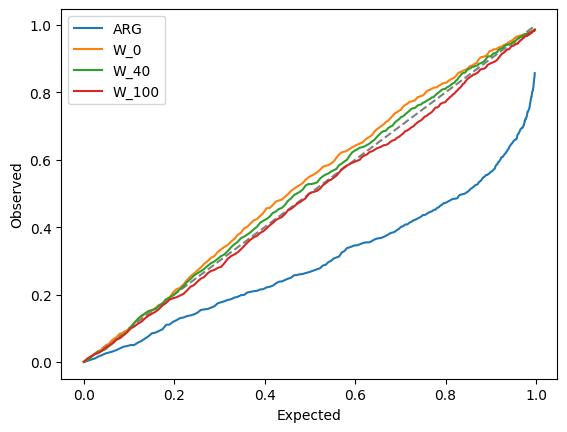

In [151]:
plt.plot(expected_percent_within, expected_percent_within, color="gray", linestyle='dashed')
plt.plot(expected_percent_within, percent_within_arg, label="ARG")
plt.plot(expected_percent_within, percent_within_w0, label="W_0")
plt.plot(expected_percent_within, percent_within_w40, label="W_40")
plt.plot(expected_percent_within, percent_within_w100, label="W_100")
plt.xlabel("Expected")
plt.ylabel("Observed")
plt.legend()
plt.show()

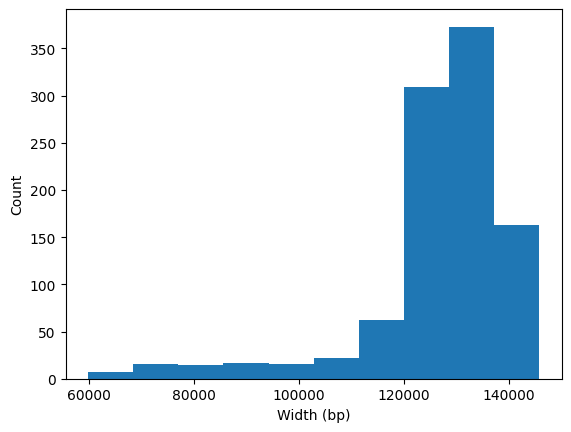

In [152]:
def store_window_bounds(row, spatial_arg, window_size, use_theoretical_dispersal=False):
    left, right = get_window_bounds(genome_pos=row["interval_left"], spatial_arg=spatial_arg, window_size=window_size)
    return pd.Series({"left":left, "right": right})

window_sizes = random_ancestors.apply(store_window_bounds, spatial_arg=spatial_arg, window_size=100, axis=1)
window_sizes["width"] = window_sizes["right"] - window_sizes["left"]

plt.hist(window_sizes["width"])
plt.xlabel("Width (bp)")
plt.ylabel("Count")
plt.show()


## Checking sample coalescence

How many samples don't coalescence with any of the samples before the cutoff? We would not have any spatial information for these samples so it would be concerning if there were many.

In [163]:
def determine_if_isolated(tree, u, ts):
    u = tree.parent(u)
    while u != -1:
        if ts.node(u).flags == 0:
            return False
        u = tree.parent(u)
    return True

for tree in spatial_arg.ts.trees():
    for sample in tree.samples():
        if determine_if_isolated(tree, sample, spatial_arg.ts):
            print(sample)

Checking this in each tree individually, we don't find any samples that lack a coalescence event before the cutoff, so we do not need to worry about this.

In [164]:
random_ancestors.to_csv("random_ancestors.csv")